# Read in data


In [22]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
#hello

In [23]:
out = pd.read_csv(r'data/output_clean.csv')
out.head()

,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,2ABD_HUMAN,...,ZN346_HUMAN,ZNF76_HUMAN,dt_start,dt_end,dose,group,age,sex,gr,suicide
0,-0.482358,-0.377167,0.408312,0.114755,-0.221734,-0.094979,-0.594402,-0.062665,0.075711,0.012887,...,-0.506843,-0.233866,80515,82115,2,c,66,Male,C,Non-Suic
1,0.096314,-0.390258,-0.416978,0.361850,0.423957,0.183221,-0.161553,0.100186,0.614246,0.547567,...,0.445916,0.029326,80515,83115,4,c,66,Male,C,Non-Suic
2,-0.127514,-0.350314,-0.907252,-0.798618,0.550538,-0.218804,-0.341688,-0.062510,-0.507460,-0.004003,...,1.198785,-0.748341,80515,90215,5,a,31,Female,MDD*SSRI,Suicide
3,-0.152157,-0.371558,-0.563748,-0.657674,0.321579,0.207347,-0.543700,-0.262971,-0.448623,-0.738267,...,1.111894,-0.128839,80515,91515,5,a,31,Female,MDD*SSRI,Suicide
4,-1.060055,-0.727050,-0.939338,-0.886080,-1.450801,-0.603545,-1.155046,-0.872522,-1.008205,-0.419715,...,-0.319368,-0.137329,80515,82115,2,c,25,Male,C,Non-Suic


In [24]:
# Check for Missing data (none)
missing_percentage = out.isnull().sum() * 100 / len(out)
missing_percentage[missing_percentage != 0]

Series([], dtype: float64)

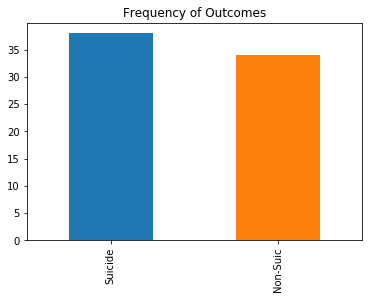

In [25]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Count of suicide/non-suicide
out.suicide.value_counts().plot(kind = 'bar', title = 'Frequency of Outcomes')

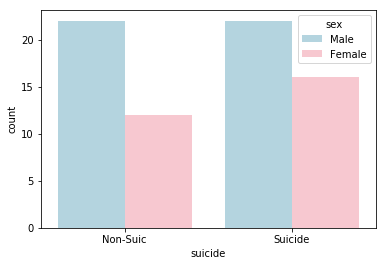

In [26]:
# Suicide/non-suicide broken down by gender

ax = sns.countplot(x="suicide", hue="sex", data=out, palette = ['lightblue', 'pink'])

Text(0.5,0,'Age')

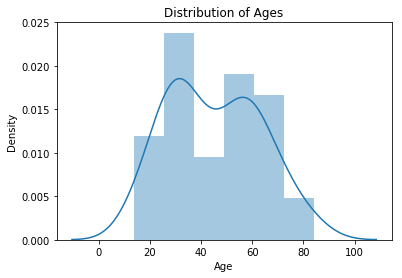

In [27]:
# distribution of ages

ax = sns.distplot(out['age'])
ax.set_title('Distribution of Ages')
ax.set_ylabel('Density')
ax.set_xlabel('Age')

Text(0.5,0,'Age')

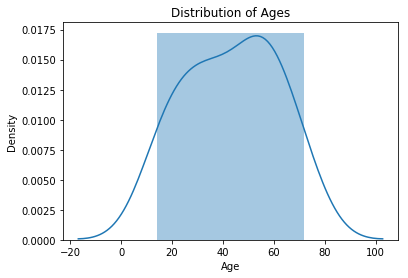

In [28]:
ax = sns.distplot(out[out['gr'] == 'C']['age'])
ax.set_title('Distribution of Ages')
ax.set_ylabel('Density')
ax.set_xlabel('Age')

Text(0.5,0,'Age')

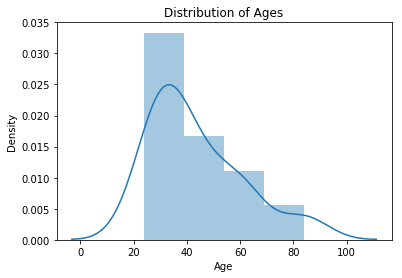

In [29]:
ax = sns.distplot(out[out['gr'] == 'MDD*SSRI']['age'])
ax.set_title('Distribution of Ages')
ax.set_ylabel('Density')
ax.set_xlabel('Age')

Text(0.5,0,'Age')

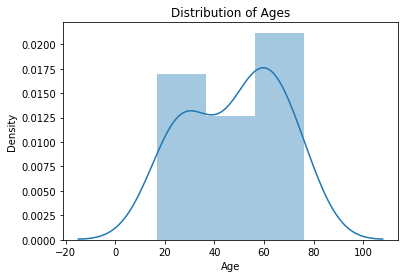

In [30]:
ax = sns.distplot(out[out['gr'] == 'MDD']['age'])
ax.set_title('Distribution of Ages')
ax.set_ylabel('Density')
ax.set_xlabel('Age')

In [31]:
# okay we matched on range, but it seems like it is not matched by age

Text(0.5,1,'Gender Frequency across Treatments')

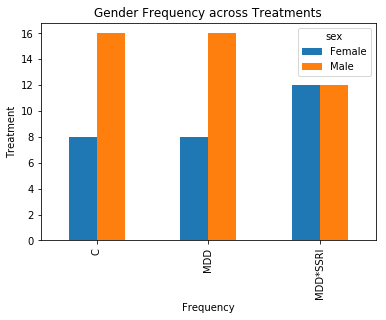

In [32]:
# Gender freq across treatments 

ct = pd.crosstab(out.gr,out.sex)
ax = ct.plot.bar()
ax.set_xlabel('Frequency')
ax.set_ylabel('Treatment')
ax.set_title('Gender Frequency across Treatments')

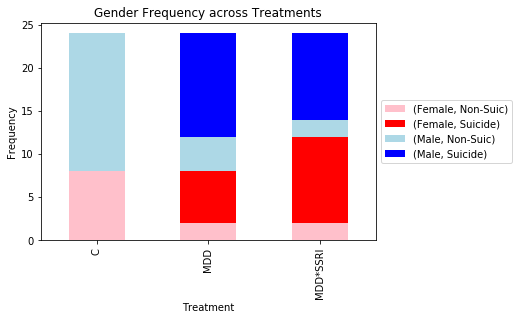

In [33]:
ct = pd.crosstab(out.gr,[out.sex, out.suicide])
ax = ct.plot.bar(stacked = True, color = ['pink', 'red', 'lightblue', 'blue'])
ax.set_ylabel('Frequency')
ax.set_xlabel('Treatment')
ax.set_title('Gender Frequency across Treatments')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [34]:
#Two sample T-test between groups A, B
# Ho: No diff between protein concentrations amongst control and mdd
# Ha: Diff in protein concentrations

from scipy import stats

group1 = 'C'
group2 = 'MDD'

def ttest_all_proteins(group1, group2):
    print('Running 2 sample t-test for ' + group1 + ' and ' + group2 + ' ...')
    d = {}
    stat_sig_proteins = []
    for col in out.columns[0:-8]: # iterate through all protein columns (non-demographic)
        control = out[out['gr'] == group1][col]
        mdd = out[out['gr'] == group2][col]
        p_val = stats.ttest_ind(control,mdd)[1]
        if p_val < 0.05:
            stat_sig_proteins.append(col)
        d[col] = p_val
    return d, stat_sig_proteins

In [35]:
# Do non parametric tests instead?


# Grabs the len of first output => len of dictionary filled with p-value results of ttest for each protein
len(ttest_all_proteins(group1, group2)[0])

Running 2 sample t-test for C and MDD ...


1131

In [36]:
# Return len of the second output => the groups have stat sig diff prot. concentrations for these proteins
len(ttest_all_proteins(group1, group2)[1])

Running 2 sample t-test for C and MDD ...


48

In [37]:
# We can also do an ANOVA across three groups to see if there is a stat sig diff in means of the prot concentrations

group1 = 'C'
group2 = 'MDD'
group3 = 'MDD*SSRI'

print('Running Anova test for ' + group1 + ', ' + group2 + ', and ' + group3 + ' ...')
d_anova = {}
stat_sig_proteins_anova = []
for col in out.columns[0:-8]:
    control = out[out['gr'] == group1][col]
    mdd = out[out['gr'] == group2][col]
    mdd_ssri = out[out['gr'] == group3][col]
    
    p_val = stats.f_oneway(control,mdd, mdd_ssri)[1]
    if p_val < 0.05:
        stat_sig_proteins_anova.append(col)
    d_anova[col] = p_val


Running Anova test for C, MDD, and MDD*SSRI ...


In [38]:
# stat_sig_proteins_anova contains list of proteins that has stat sig diff in concentrations btw 2 groups
# deal with outliers (throw out largest and smallest of each group)
# box cox transformation

len(stat_sig_proteins_anova)

152

In [39]:
# More analysis: remove dates

out_no_dates = out.drop(columns=['dt_start', 'dt_end', 'group'])

In [40]:
# One hot encoding and drop original columns

cat_cols = ['dose', 'sex', 'gr']
out_tmp = pd.concat([out_no_dates,pd.get_dummies(out_no_dates[cat_cols])],axis=1)
out_new = out_tmp.drop(['dose', 'sex', 'gr'], axis = 1)

In [41]:
# Change suicide column to 0,1s
out_new.loc[out_new['suicide'] == 'Non-Suic','suicide'] = 0
out_new.loc[out_new['suicide'] == 'Suicide','suicide'] = 1

# Check one-hot encoding in suicide column
out_new['suicide'][0:5]

C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0    0
1    0
2    1
3    1
4    0
Name: suicide, dtype: int64

In [42]:
df1 = out_new.pop('suicide') # remove column suicide and store it in df1
out_new['suicide']=df1 # add suicide series as a 'new' column.

C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
list(out_new.columns).index('suicide')

1137

In [44]:
out_no_gr = out_new.drop(['gr_C', 'gr_MDD', 'gr_MDD*SSRI'], axis = 1)

In [45]:
# Feature importances using Extra Trees Classifier
#with gr

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=100)
model.fit(out_new.iloc[:,0:-1], out_new.suicide)
df = pd.DataFrame(model.feature_importances_)
df.index = out_new.columns[:-1]
df.columns = ['Feature_importance']
d_f = df.sort_values(['Feature_importance'], ascending = False)
top_ten = d_f.head(10)

In [46]:
top_ten

,Feature_importance
gr_C,0.041855
gr_MDD,0.013915
gr_MDD*SSRI,0.009909
SYFA_HUMAN,0.006299
CPNE1_HUMAN,0.006219
PP1G_HUMAN,0.005883
RB6I2_HUMAN,0.005688
GEPH_HUMAN,0.004316
6PGL_HUMAN,0.004077
MA2A1_HUMAN,0.004063


Text(0.5,1,'Top 10 Feature Importances')

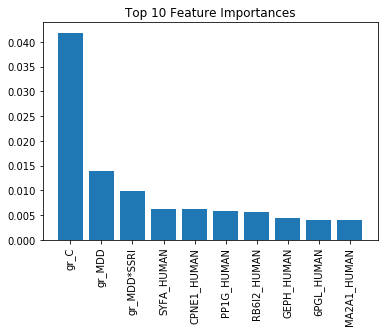

In [47]:
plt.figure()
plt.bar(top_ten.index, top_ten['Feature_importance'])
plt.xticks(rotation = 'vertical')
plt.title('Top 10 Feature Importances')

In [48]:
# without gr
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=100)
model.fit(out_no_gr.iloc[:,0:-1], out_no_gr.suicide)
df = pd.DataFrame(model.feature_importances_)
df.index = out_no_gr.columns[:-1]
df.columns = ['Feature_importance']
d_f = df.sort_values(['Feature_importance'], ascending = False)
top_ten = d_f.head(10)

In [49]:
top_ten

,Feature_importance
ZNF76_HUMAN,0.006074
SNTA1_HUMAN,0.005440
H2B1A_HUMAN,0.005283
RAB18_HUMAN,0.005283
GUAD_HUMAN,0.005066
VAMP3_HUMAN,0.005057
MAP4_HUMAN,0.004367
PHLB3_HUMAN,0.004365
HBE_HUMAN,0.004351
CN159_HUMAN,0.004193


Text(0.5,1,'Top 10 Feature Importances')

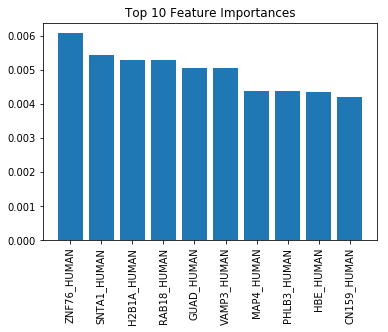

In [50]:
plt.figure()
plt.bar(top_ten.index, top_ten['Feature_importance'])
plt.xticks(rotation = 'vertical')
plt.title('Top 10 Feature Importances')

# Biostats Visualizations

In [51]:
out_new.head()

,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,2ABD_HUMAN,...,ZBT26_HUMAN,ZN346_HUMAN,ZNF76_HUMAN,age,sex_Female,sex_Male,gr_C,gr_MDD,gr_MDD*SSRI,suicide
0,-0.482358,-0.377167,0.408312,0.114755,-0.221734,-0.094979,-0.594402,-0.062665,0.075711,0.012887,...,-0.183583,-0.506843,-0.233866,66,0,1,1,0,0,0
1,0.096314,-0.390258,-0.416978,0.361850,0.423957,0.183221,-0.161553,0.100186,0.614246,0.547567,...,-0.023866,0.445916,0.029326,66,0,1,1,0,0,0
2,-0.127514,-0.350314,-0.907252,-0.798618,0.550538,-0.218804,-0.341688,-0.062510,-0.507460,-0.004003,...,-0.123737,1.198785,-0.748341,31,1,0,0,0,1,1
3,-0.152157,-0.371558,-0.563748,-0.657674,0.321579,0.207347,-0.543700,-0.262971,-0.448623,-0.738267,...,-0.066387,1.111894,-0.128839,31,1,0,0,0,1,1
4,-1.060055,-0.727050,-0.939338,-0.886080,-1.450801,-0.603545,-1.155046,-0.872522,-1.008205,-0.419715,...,0.901341,-0.319368,-0.137329,25,0,1,1,0,0,0


In [52]:
out.head()

,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,2ABD_HUMAN,...,ZN346_HUMAN,ZNF76_HUMAN,dt_start,dt_end,dose,group,age,sex,gr,suicide
0,-0.482358,-0.377167,0.408312,0.114755,-0.221734,-0.094979,-0.594402,-0.062665,0.075711,0.012887,...,-0.506843,-0.233866,80515,82115,2,c,66,Male,C,Non-Suic
1,0.096314,-0.390258,-0.416978,0.361850,0.423957,0.183221,-0.161553,0.100186,0.614246,0.547567,...,0.445916,0.029326,80515,83115,4,c,66,Male,C,Non-Suic
2,-0.127514,-0.350314,-0.907252,-0.798618,0.550538,-0.218804,-0.341688,-0.062510,-0.507460,-0.004003,...,1.198785,-0.748341,80515,90215,5,a,31,Female,MDD*SSRI,Suicide
3,-0.152157,-0.371558,-0.563748,-0.657674,0.321579,0.207347,-0.543700,-0.262971,-0.448623,-0.738267,...,1.111894,-0.128839,80515,91515,5,a,31,Female,MDD*SSRI,Suicide
4,-1.060055,-0.727050,-0.939338,-0.886080,-1.450801,-0.603545,-1.155046,-0.872522,-1.008205,-0.419715,...,-0.319368,-0.137329,80515,82115,2,c,25,Male,C,Non-Suic


In [53]:
len(out.columns)

1139

In [54]:
l = list(range(1131))
l.append(1137)
l.append(1135)

In [55]:
out_trunc = out.iloc[:,l]
out_trunc.head()

,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,2ABD_HUMAN,...,WIPF3_HUMAN,XPP3_HUMAN,XRCC6_HUMAN,YD018_HUMAN,YKT6_HUMAN,ZBT26_HUMAN,ZN346_HUMAN,ZNF76_HUMAN,gr,age
0,-0.482358,-0.377167,0.408312,0.114755,-0.221734,-0.094979,-0.594402,-0.062665,0.075711,0.012887,...,0.332670,1.303209,0.042009,0.659225,-0.062723,-0.183583,-0.506843,-0.233866,C,66
1,0.096314,-0.390258,-0.416978,0.361850,0.423957,0.183221,-0.161553,0.100186,0.614246,0.547567,...,0.119888,0.427999,0.052063,1.794978,0.263402,-0.023866,0.445916,0.029326,C,66
2,-0.127514,-0.350314,-0.907252,-0.798618,0.550538,-0.218804,-0.341688,-0.062510,-0.507460,-0.004003,...,0.179554,-0.701155,0.137352,-0.220313,0.270782,-0.123737,1.198785,-0.748341,MDD*SSRI,31
3,-0.152157,-0.371558,-0.563748,-0.657674,0.321579,0.207347,-0.543700,-0.262971,-0.448623,-0.738267,...,0.227330,-0.273078,0.020129,-0.089911,-0.281992,-0.066387,1.111894,-0.128839,MDD*SSRI,31
4,-1.060055,-0.727050,-0.939338,-0.886080,-1.450801,-0.603545,-1.155046,-0.872522,-1.008205,-0.419715,...,0.017187,-0.262792,-0.661565,-0.728885,-0.666499,0.901341,-0.319368,-0.137329,C,25


In [56]:
pivot = pd.pivot_table(out_trunc, index = ['gr', 'age'])

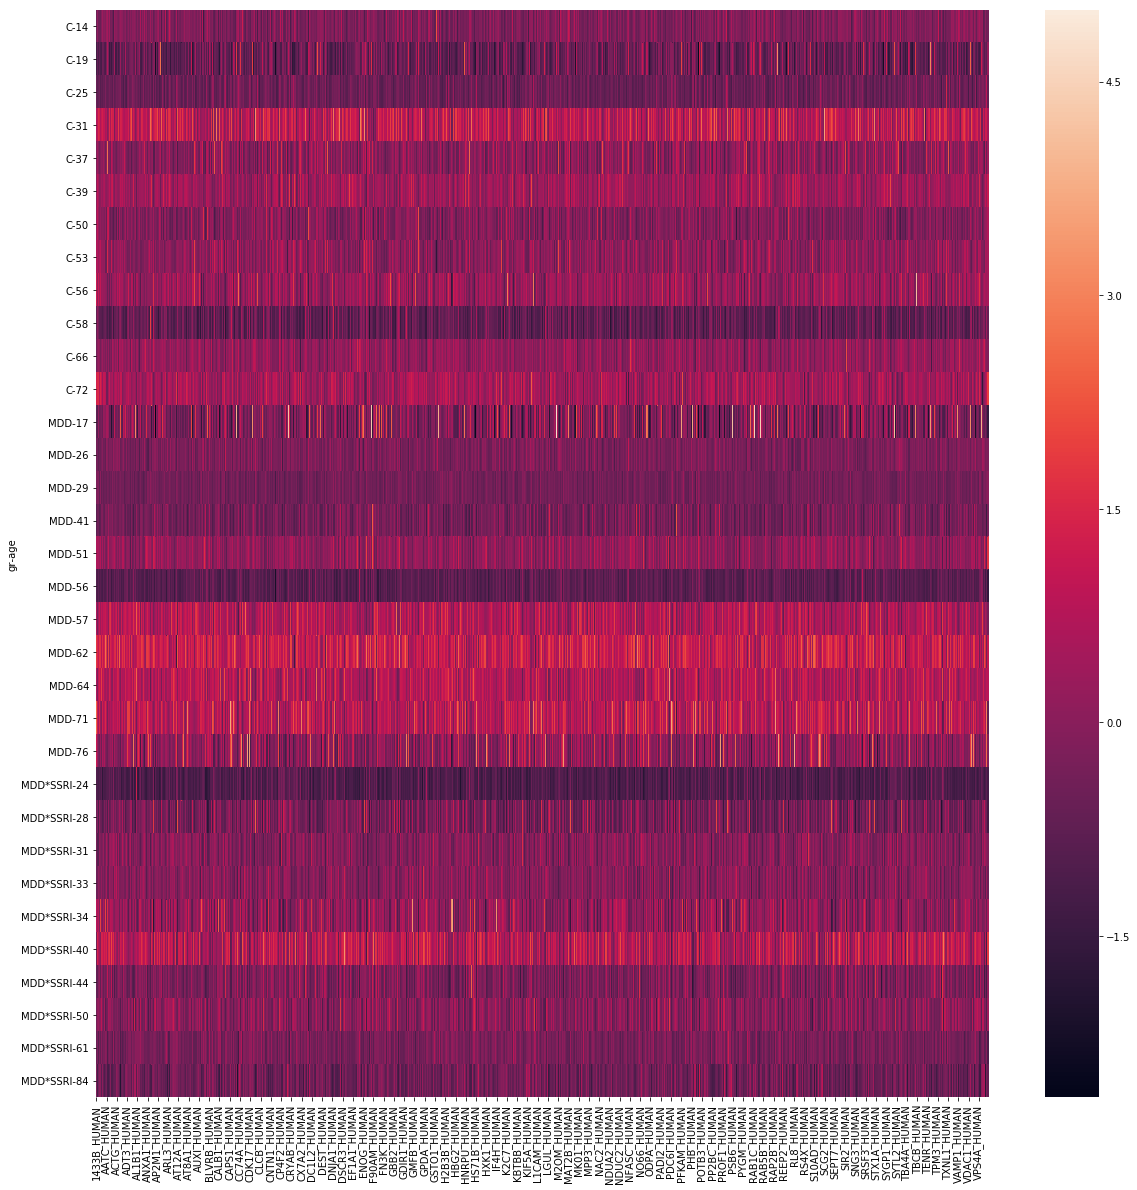

In [57]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(pivot)

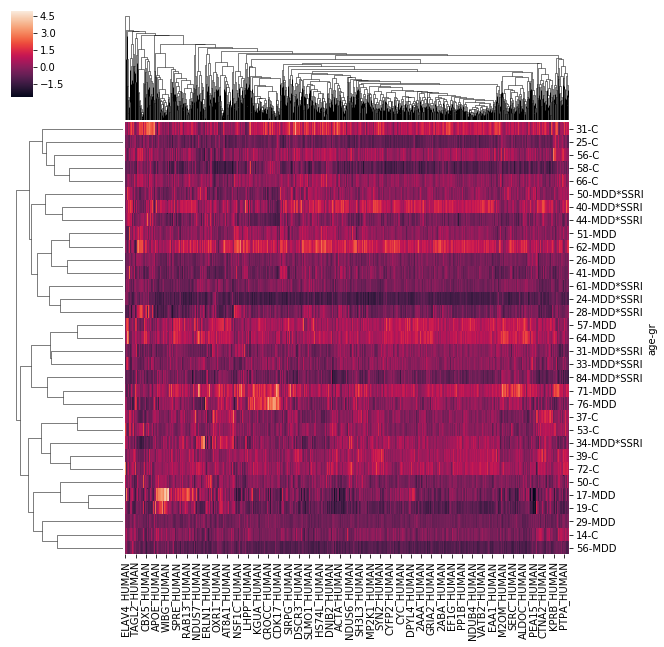

In [58]:
_pivot = pd.pivot_table(out_trunc, index = ['age', 'gr'])
p1 = sns.clustermap(_pivot, metric = 'correlation')
# https://seaborn.pydata.org/generated/seaborn.clustermap.html
# https://plot.ly/ipython-notebooks/bioinformatics/

# Heatmaps using log transformed data

In [59]:
final_df = pd.read_csv(r'data/output_clean.csv')
final_df.head()

,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,2ABD_HUMAN,...,ZN346_HUMAN,ZNF76_HUMAN,dt_start,dt_end,dose,group,age,sex,gr,suicide
0,-0.482358,-0.377167,0.408312,0.114755,-0.221734,-0.094979,-0.594402,-0.062665,0.075711,0.012887,...,-0.506843,-0.233866,80515,82115,2,c,66,Male,C,Non-Suic
1,0.096314,-0.390258,-0.416978,0.361850,0.423957,0.183221,-0.161553,0.100186,0.614246,0.547567,...,0.445916,0.029326,80515,83115,4,c,66,Male,C,Non-Suic
2,-0.127514,-0.350314,-0.907252,-0.798618,0.550538,-0.218804,-0.341688,-0.062510,-0.507460,-0.004003,...,1.198785,-0.748341,80515,90215,5,a,31,Female,MDD*SSRI,Suicide
3,-0.152157,-0.371558,-0.563748,-0.657674,0.321579,0.207347,-0.543700,-0.262971,-0.448623,-0.738267,...,1.111894,-0.128839,80515,91515,5,a,31,Female,MDD*SSRI,Suicide
4,-1.060055,-0.727050,-0.939338,-0.886080,-1.450801,-0.603545,-1.155046,-0.872522,-1.008205,-0.419715,...,-0.319368,-0.137329,80515,82115,2,c,25,Male,C,Non-Suic


In [60]:
# Using log transformed data
import pandas as pd
import numpy as np

final_df = pd.read_csv(r'data/final_df.csv')
final_df = final_df.iloc[:,3:]
a = final_df.iloc[:,0:-8]
b= final_df.iloc[:,-4:]
b

,age,sex.1,gr.1,suicide
0,56,Female,C,Non-Suic
1,56,Female,C,Non-Suic
2,72,Female,C,Non-Suic
3,72,Female,C,Non-Suic
4,50,Female,C,Non-Suic
5,50,Female,C,Non-Suic
6,14,Female,C,Non-Suic
7,14,Female,C,Non-Suic
8,41,Female,MDD,Suicide
9,41,Female,MDD,Suicide


In [61]:
l = list(range(1131))
l.append(1137)
l.append(1135)

final_df_trunc = final_df.iloc[:,l]
final_df_trunc.head()

,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,2ABD_HUMAN,...,WIPF3_HUMAN,XPP3_HUMAN,XRCC6_HUMAN,YD018_HUMAN,YKT6_HUMAN,ZBT26_HUMAN,ZN346_HUMAN,ZNF76_HUMAN,gr.1,age
0,13.787726,14.778525,14.071394,14.665839,11.264794,13.055630,16.054861,14.048699,12.969326,13.157697,...,10.927401,11.945771,10.797801,11.149859,12.324365,13.450442,11.115703,10.703296,C,56
1,14.045300,15.033390,14.105815,14.796045,11.599565,13.334591,16.357768,14.273443,13.223441,13.367290,...,11.001530,11.623600,11.173431,11.741158,12.414220,13.572839,11.384135,10.716819,C,56
2,13.809070,14.662353,14.213875,14.537931,10.617070,13.053167,15.990168,14.066942,12.777811,12.971277,...,10.151836,10.975863,10.943868,10.749525,12.186666,13.439400,11.009725,10.938700,C,72
3,14.433435,15.185840,14.511720,15.045655,11.579429,13.493932,16.561863,14.597817,13.323174,13.525679,...,10.679469,11.932201,11.409193,11.630486,12.547470,13.916300,11.386591,11.079631,C,72
4,13.372266,14.296781,14.082546,14.174213,10.010893,12.701251,15.542761,13.725006,12.778088,12.781619,...,10.391038,10.292209,9.596585,10.681553,12.174987,13.133127,10.675698,10.809151,C,50


In [64]:
pivot_df = pd.pivot_table(final_df_trunc, index = ['gr.1', 'age'])

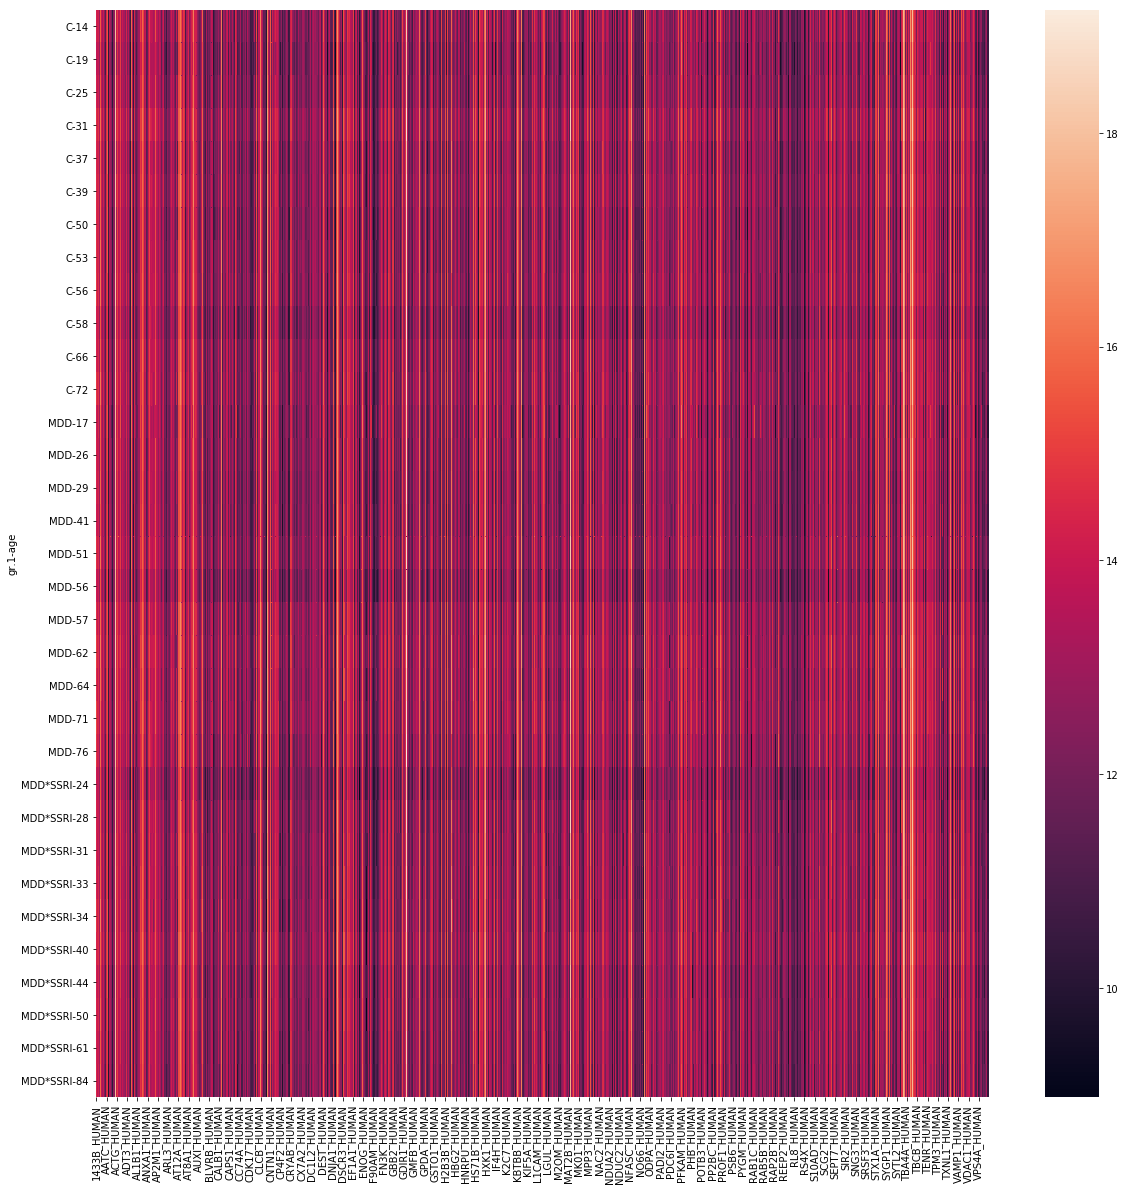

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(pivot_df)

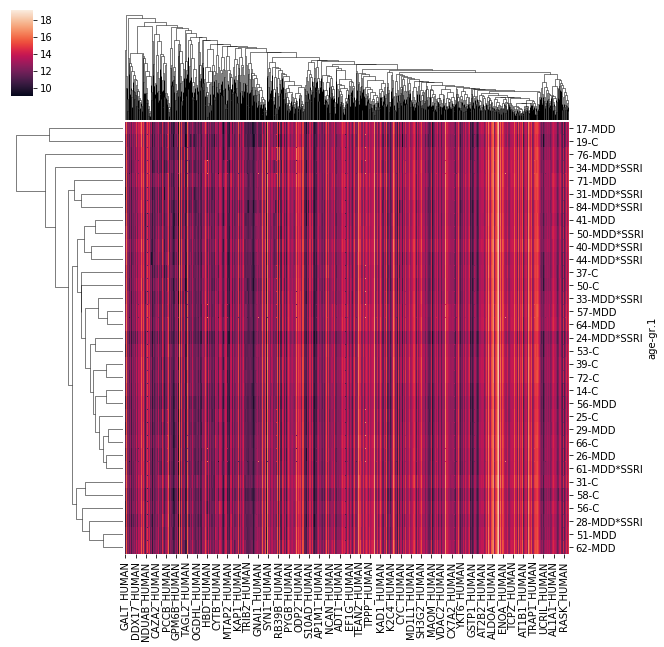

In [66]:
_df_pivot = pd.pivot_table(final_df_trunc, index = ['age', 'gr.1'])
p2 = sns.clustermap(_df_pivot, metric = 'correlation')

# Visualizing just top 10

### Non log transformed

In [75]:
top_ten_list = list(top_ten.index.values)
top_ten_list.append('gr')
top_ten_list.append('age')
top_ten_list

['ZNF76_HUMAN',
 'SNTA1_HUMAN',
 'H2B1A_HUMAN',
 'RAB18_HUMAN',
 'GUAD_HUMAN',
 'VAMP3_HUMAN',
 'MAP4_HUMAN',
 'PHLB3_HUMAN',
 'HBE_HUMAN',
 'CN159_HUMAN',
 'gr',
 'age']

In [76]:
out_filter = out_trunc.loc[:,out_trunc.columns.isin(top_ten_list)]
out_filter.head()

,CN159_HUMAN,GUAD_HUMAN,H2B1A_HUMAN,HBE_HUMAN,MAP4_HUMAN,PHLB3_HUMAN,RAB18_HUMAN,SNTA1_HUMAN,VAMP3_HUMAN,ZNF76_HUMAN,gr,age
0,0.139170,0.182471,0.506241,0.768917,-0.347064,-0.991880,0.077283,0.692095,1.568898,-0.233866,C,66
1,0.192978,0.808534,-0.259353,0.932572,0.547716,-0.098862,-0.406245,0.566529,1.554573,0.029326,C,66
2,-0.667863,0.621013,-0.459505,-0.746712,0.278929,1.083190,-0.516104,-0.142725,-0.815412,-0.748341,MDD*SSRI,31
3,-0.873812,0.646087,-0.180638,-0.742055,0.160568,1.608336,-0.052822,-0.513685,-0.391609,-0.128839,MDD*SSRI,31
4,-0.105173,-0.463243,-0.780231,-0.111230,-1.354295,-1.520579,0.246601,-0.061789,0.616579,-0.137329,C,25


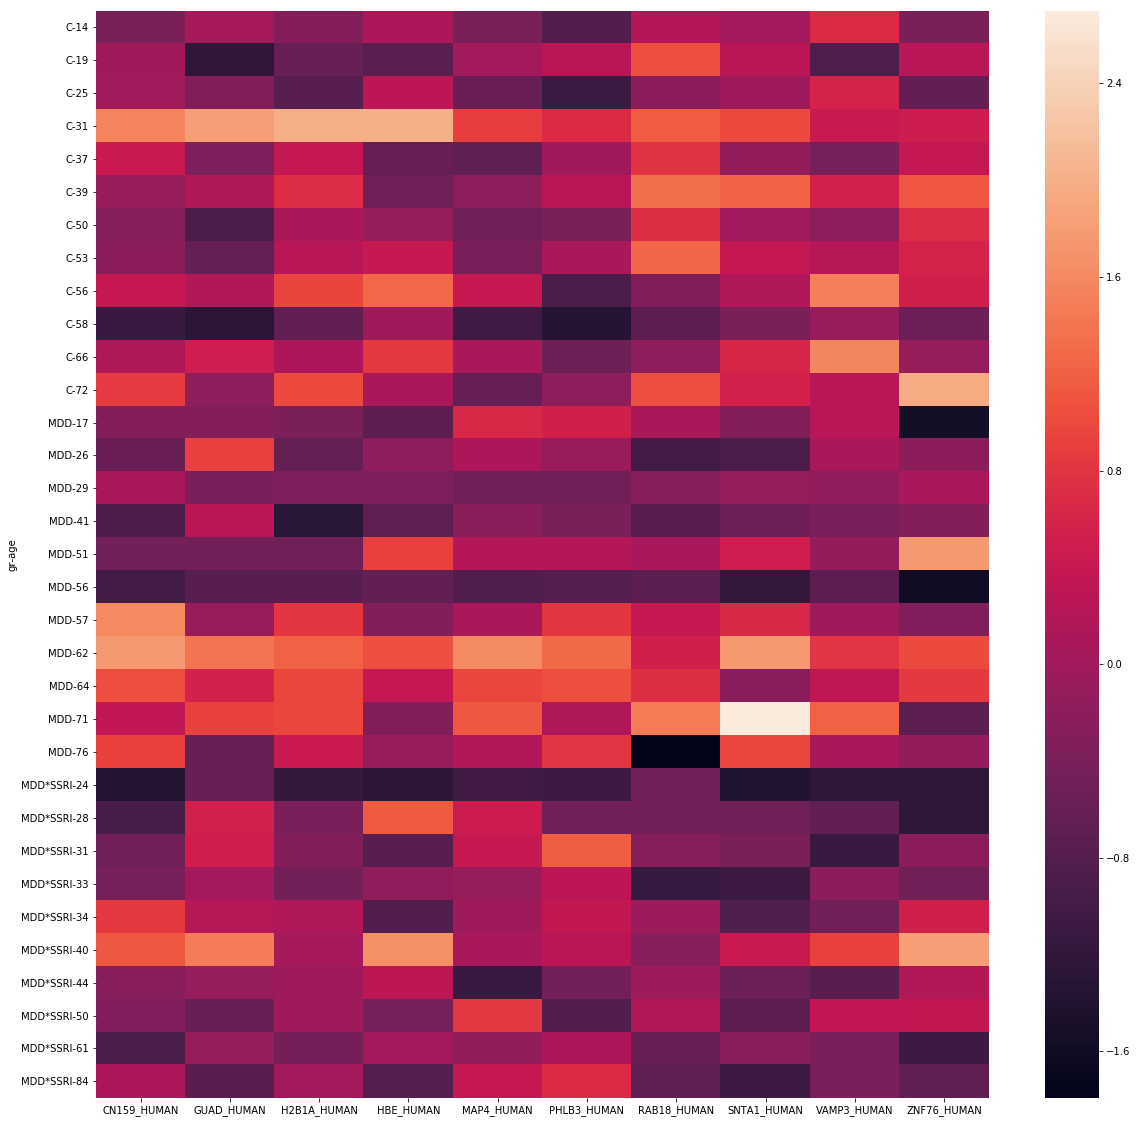

In [77]:
pivot_2 = pd.pivot_table(out_filter, index = ['gr', 'age'])
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(pivot_2)

In [ ]:
# select prot based on groups
# overall aging pvalue (pool all groupstogether)

# 3 aging pvalues- one for each group
# top proteins

 #order by suicide/non-suicide 

In [80]:
top_ten_list

['ZNF76_HUMAN',
 'SNTA1_HUMAN',
 'H2B1A_HUMAN',
 'RAB18_HUMAN',
 'GUAD_HUMAN',
 'VAMP3_HUMAN',
 'MAP4_HUMAN',
 'PHLB3_HUMAN',
 'HBE_HUMAN',
 'CN159_HUMAN',
 'gr',
 'age']

### With log correlation 

In [ ]:
df_filter = final_df_trunc.loc[:,final_df_trunc.columns.isin(top_ten_list)]
df_filter.head()

In [ ]:
pivot_3 = pd.pivot_table(df_filter, index = ['gr', 'age'])
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(pivot_3)

### Correlations heatmap

In [ ]:
out_filter_pivot = pd.pivot_table(out_filter, index = ['age', 'gr'])
p5 = sns.clustermap(out_filter_pivot, metric = 'correlation')

In [ ]:
# GAS value - 1 to 100, v bad ->v good (global assessment scale -function before they died)
# maybe some of treated/untreated MDD have low GAS

#GAS -responders to treatment for MDD 

#Aging, group diff, and suicide/nonsuicide

In [ ]:
df_filter_pivot = pd.pivot_table(df_filter, index = ['age', 'gr'])
p4 = sns.clustermap(df_filter_pivot, metric = 'correlation')

# Week 3 Work

In [130]:
final_df = pd.read_csv(r'data/final_df.csv')
final_df.head()

,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,2ABD_HUMAN,...,ZNF76_HUMAN,dt_start,dt_end,dose,group,age,sex,gr,suicide,GAS
0,13.787726,14.778525,14.071394,14.665839,11.264794,13.055630,16.054861,14.048699,12.969326,13.157697,...,10.703296,80515,82115,2,c,56,Female,C,Non-Suic,86
1,14.045300,15.033390,14.105815,14.796045,11.599565,13.334591,16.357768,14.273443,13.223441,13.367290,...,10.716819,80515,83115,4,c,56,Female,C,Non-Suic,86
2,13.809070,14.662353,14.213875,14.537931,10.617070,13.053167,15.990168,14.066942,12.777811,12.971277,...,10.938700,80515,82115,2,c,72,Female,C,Non-Suic,85
3,14.433435,15.185840,14.511720,15.045655,11.579429,13.493932,16.561863,14.597817,13.323174,13.525679,...,11.079631,80515,83115,6,c,72,Female,C,Non-Suic,85
4,13.372266,14.296781,14.082546,14.174213,10.010893,12.701251,15.542761,13.725006,12.778088,12.781619,...,10.809151,80515,82115,2,c,50,Female,C,Non-Suic,70


In [131]:
top_ten_list.append('sex')
top_ten_list.append('suicide')
top_ten_list.append('GAS')

In [132]:
final_df_top_ten = final_df.loc[:,final_df.columns.isin(top_ten_list)]
final_df_top_ten[0:10]

,CN159_HUMAN,GUAD_HUMAN,H2B1A_HUMAN,HBE_HUMAN,MAP4_HUMAN,PHLB3_HUMAN,RAB18_HUMAN,SNTA1_HUMAN,VAMP3_HUMAN,ZNF76_HUMAN,age,sex,gr,suicide,GAS
0,11.539449,13.527398,12.208505,12.298352,12.352357,12.865606,10.856568,12.198185,11.772865,10.703296,56,Female,C,Non-Suic,86
1,11.838565,13.828997,12.295681,12.385953,12.835166,13.203114,10.612559,12.104603,11.864794,10.716819,56,Female,C,Non-Suic,86
2,11.364559,13.311629,12.117469,11.885080,11.613422,12.933244,11.013118,12.074883,11.290929,10.938700,72,Female,C,Non-Suic,85
3,12.124712,13.810277,12.387828,12.255379,12.635886,13.666505,11.174895,12.385012,11.729337,11.079631,72,Female,C,Non-Suic,85
4,11.389774,12.975972,11.610338,11.679462,11.599685,12.804547,11.105951,11.980743,10.850841,10.809151,50,Female,C,Non-Suic,70
5,11.629519,13.665882,12.388237,12.299883,12.701279,13.605690,10.934906,12.235493,11.767309,10.691380,50,Female,C,Non-Suic,70
6,11.305125,13.339374,11.816437,11.776247,11.601636,12.807646,10.920245,11.993200,11.333987,10.484424,14,Female,C,Non-Suic,100
7,11.633169,13.902034,12.119433,12.332014,12.764517,13.306889,10.863204,12.232304,11.873427,10.409722,14,Female,C,Non-Suic,100
8,11.394881,13.613636,11.683832,11.873161,12.138987,13.007016,10.660414,12.006569,11.392893,10.538290,41,Female,MDD,Suicide,45
9,11.217635,13.794541,11.689278,11.856770,12.609498,13.504445,10.544625,11.955908,11.294486,10.405822,41,Female,MDD,Suicide,45


In [133]:
final_df_top_ten['gr'][final_df_top_ten['gr'] == 'MDD*SSRI'] = 'MDD_SSRI'

C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\pandas\core\generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\IPython\core\interactiveshell.py:2961: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [134]:
final_df_top_ten.tail()

,CN159_HUMAN,GUAD_HUMAN,H2B1A_HUMAN,HBE_HUMAN,MAP4_HUMAN,PHLB3_HUMAN,RAB18_HUMAN,SNTA1_HUMAN,VAMP3_HUMAN,ZNF76_HUMAN,age,sex,gr,suicide,GAS
67,11.712272,13.818682,12.182636,12.327895,12.209911,13.483967,10.609800,12.058073,11.344891,10.618876,44,Male,MDD_SSRI,Non-Suic,41
68,11.615549,13.434278,12.002148,11.728589,12.523664,13.618417,10.690462,11.894561,11.314315,10.395233,84,Male,MDD_SSRI,Suicide,1
69,11.645597,13.411152,12.104970,11.938580,12.691211,13.645670,10.566881,11.735667,11.369293,10.300631,84,Male,MDD_SSRI,Suicide,1
70,11.065363,13.460852,11.868353,11.717646,12.349469,13.479265,10.617569,11.979081,10.937212,10.178277,61,Male,MDD_SSRI,Suicide,1
71,11.227927,13.474195,11.860466,11.834086,12.347670,13.561199,10.478598,11.899914,11.161937,10.257274,61,Male,MDD_SSRI,Suicide,1


C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using 

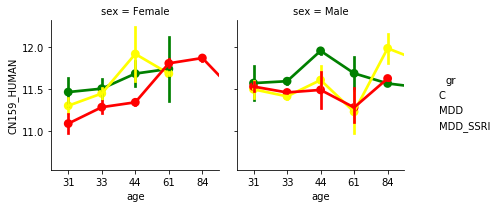

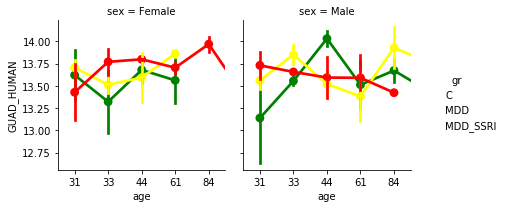

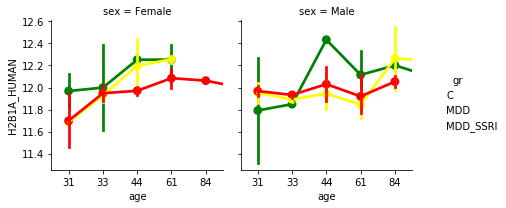

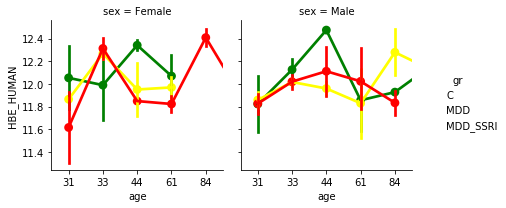

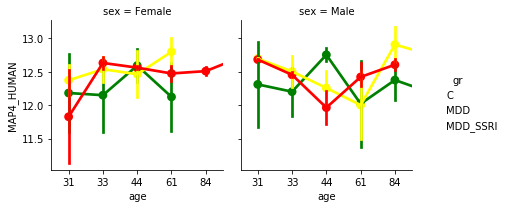

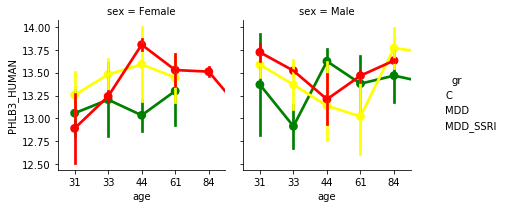

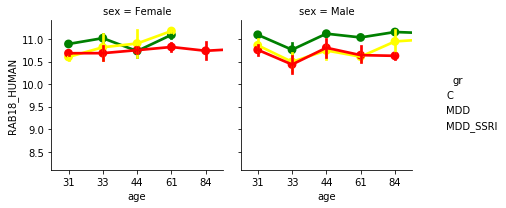

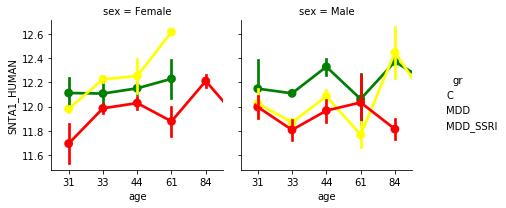

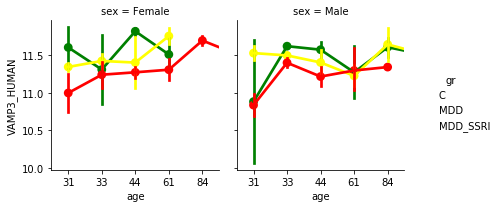

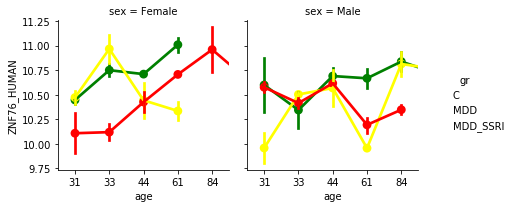

In [140]:
palette = dict(C= 'green', MDD = 'yellow', MDD_SSRI = 'red')
for prot in final_df_top_ten.columns[0:-5]:
    g = sns.FacetGrid(final_df_top_ten, col = 'sex', hue = 'gr', palette = palette)
    g.map(sns.pointplot, 'age', prot, alpha = 0.7, data = final_df_top_ten)
    g.add_legend()

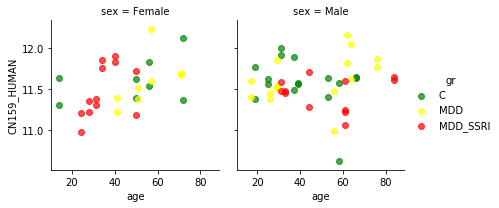

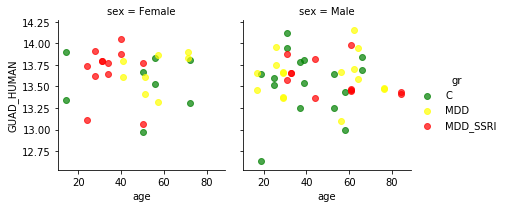

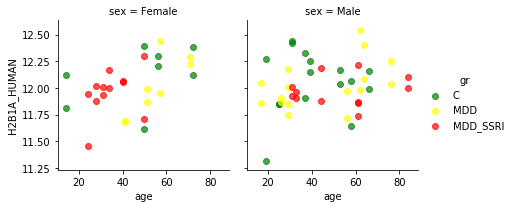

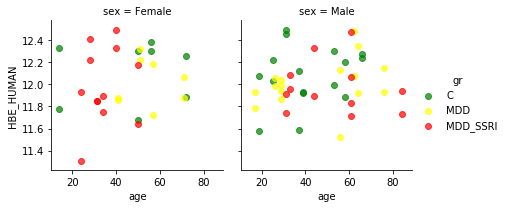

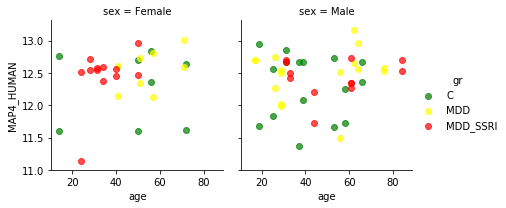

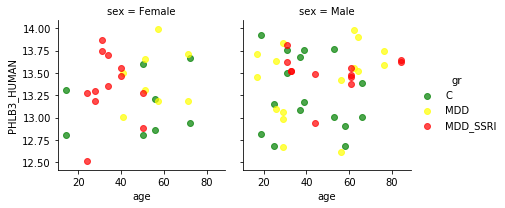

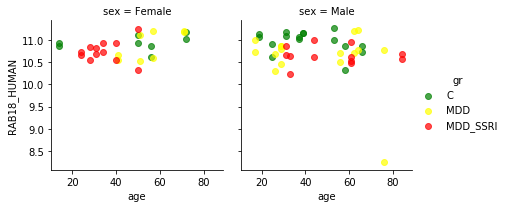

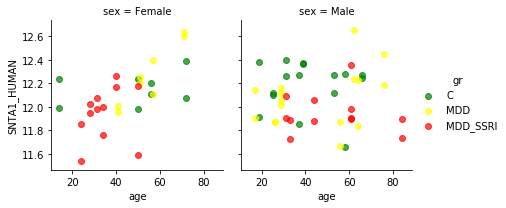

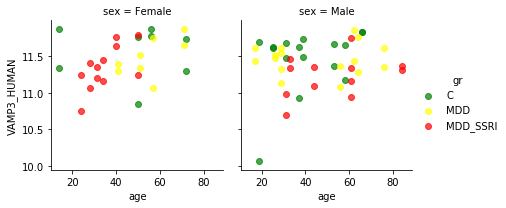

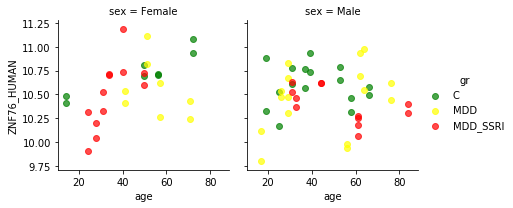

In [141]:
palette = dict(C= 'green', MDD = 'yellow', MDD_SSRI = 'red')
for prot in final_df_top_ten.columns[0:-5]:
    g = sns.FacetGrid(final_df_top_ten, col = 'sex', hue = 'gr', palette = palette)
    g = g.map(plt.scatter, 'age', prot, alpha = 0.7)
    g = g.add_legend()


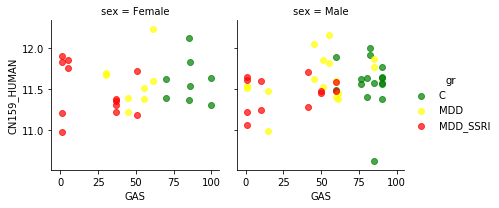

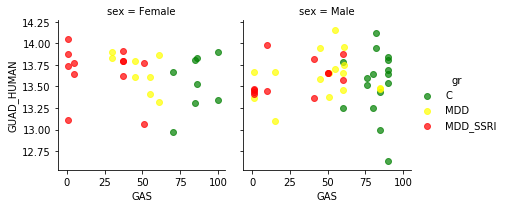

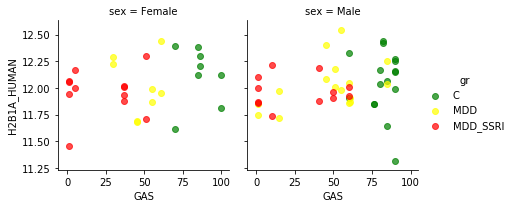

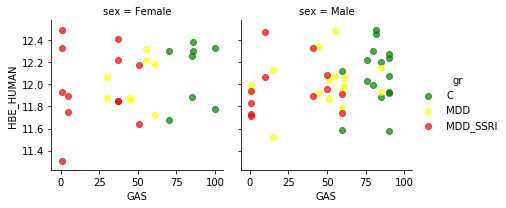

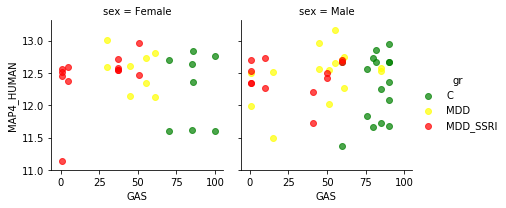

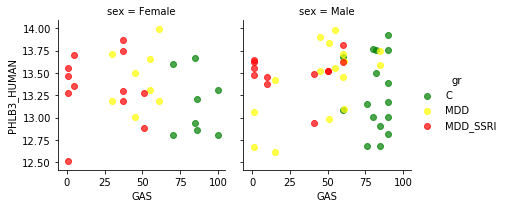

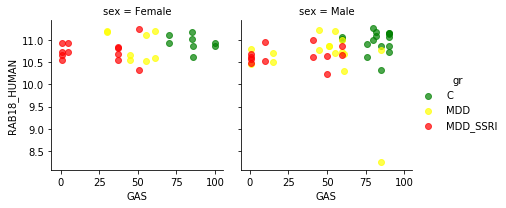

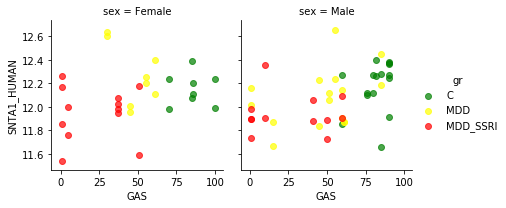

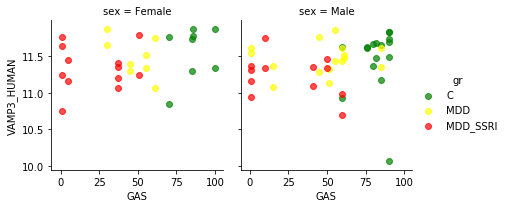

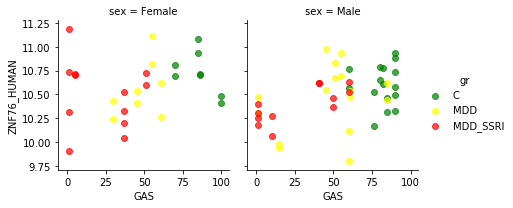

In [143]:
palette = dict(C= 'green', MDD = 'yellow', MDD_SSRI = 'red')
for prot in final_df_top_ten.columns[0:-5]:
    g = sns.FacetGrid(final_df_top_ten, col = 'sex', hue = 'gr', palette = palette)
    g.map(plt.scatter, 'GAS', prot, alpha = 0.7, data = final_df_top_ten)
    g.add_legend()

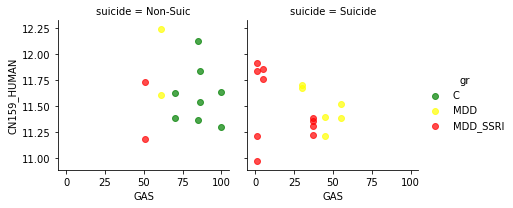

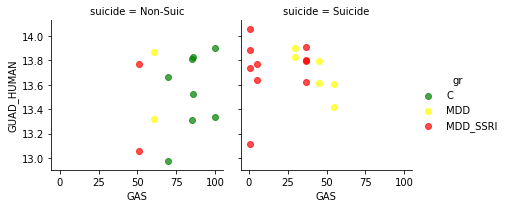

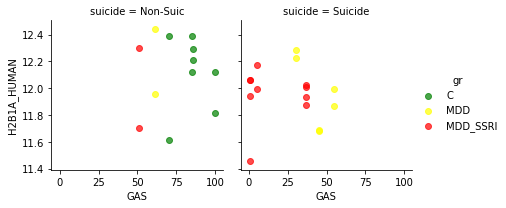

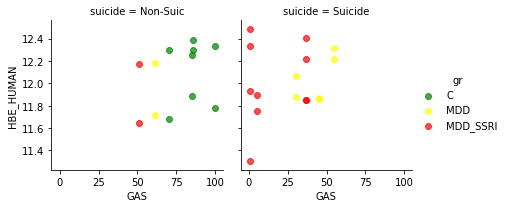

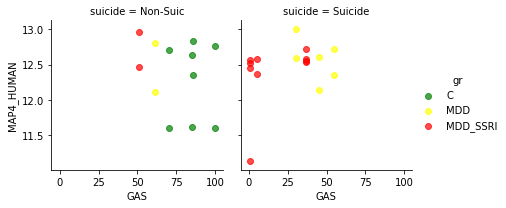

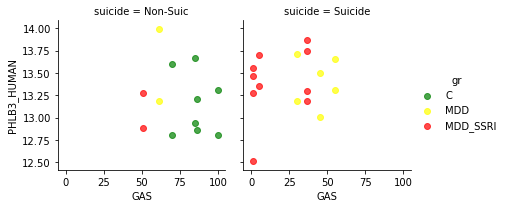

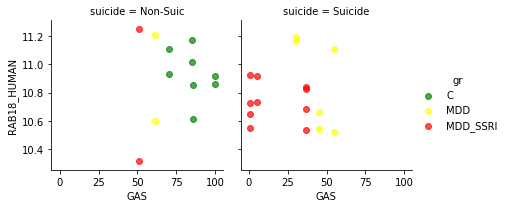

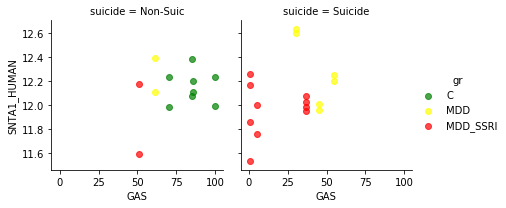

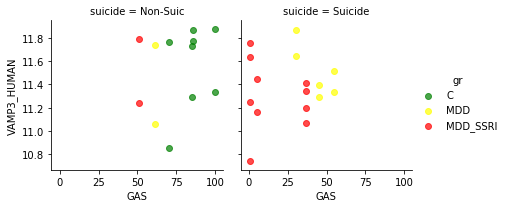

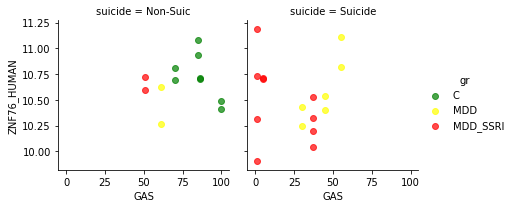

In [145]:
palette = dict(C= 'green', MDD = 'yellow', MDD_SSRI = 'red')
for prot in final_df_top_ten.columns[0:-5]:
    g = sns.FacetGrid(final_df_top_ten.loc[final_df_top_ten['sex'] == 'Female',:], col = 'suicide', hue = 'gr', palette = palette)
    g.map(plt.scatter, 'GAS', prot, alpha = 0.7, data = final_df_top_ten)
    g.add_legend()

In [ ]:
 # for example with PHLB3 protein, if the GAS is low and if protein concentration is high